# Example Notebook

This notebook is designed demonstrate a number of goals:

  - The notebook is part of the automated analytical pipeline, as it is run programmatically by the build system, as in the dodo.py file.
  - It is tracked by version control via Git. To avoid large files and the problems associated with non-text files, the notebook is stripped of its output. 
  - In order to avoid re-running the notebook every time it changes (it changes often, even by the act of opening it) and to only rerun it if meaningful changes have been made, the build system only looks for changes in the plaintext version of the notebook. That is, the notebook is converted to a Python script via [nbconvert](https://nbconvert.readthedocs.io/en/latest/), which is often packaged with Jupyter.
  Then, DoIt looks for changes to the Python version. If it detects a difference, then the notebook is re-run. (Note, that you could also convert to a Markdown file with 
  [JupyText](https://github.com/mwouts/jupytext). However, this package is often not packaged with Jupyter.)
  - Since we want to use Jupyter Notebooks for exploratory reports, we want to keep fully-computed versions of the notebook (with the output intact). However, earlier I said that I strip the notebook of its output before committing to version control. Well, to keep the output, every time PyDoit runs the notebook, it outputs an HTML version of the freshly run notebook and saves that HTML report in the `output` directory. That way, you will be able to view the finished report at any time without having to open Jupyter.

In [1]:
import config
from pathlib import Path
OUTPUT_DIR = Path(config.OUTPUT_DIR)
DATA_DIR = Path(config.DATA_DIR)
WRDS_USERNAME = config.WRDS_USERNAME

START_DATE = config.START_DATE
END_DATE = config.END_DATE

In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pathlib import Path

import numpy as np
import pandas as pd
import wrds

import config

In [3]:
db = wrds.Connection(wrds_username=WRDS_USERNAME)

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [4]:
db.list_tables(library = 'bank_all')

['wrds_bank_reg_vars',
 'wrds_call_rcfa_1',
 'wrds_call_rcfd_1',
 'wrds_call_rcfd_2',
 'wrds_call_rcfn_1',
 'wrds_call_rcfw_1',
 'wrds_call_rcoa_1',
 'wrds_call_rcon_1',
 'wrds_call_rcon_2',
 'wrds_call_rcow_1',
 'wrds_call_riad_1',
 'wrds_call_te_1',
 'wrds_holding_bhck_1',
 'wrds_holding_bhck_2',
 'wrds_holding_other_1']

#### not working on my computer……

In [5]:
query = f"""
    SELECT 
        
        rcfd_1.rssd9001, rcfd_1.rssd9050, rcfd_1.rssd9999,
        rcfd_1.rcfd0010,rcfd_1.rcfd1773,rcfd_1.rcfdg301,rcfd_1.rcfdg303,
        rcfd_1.rcfdg305,rcfd_1.rcfdg307,rcfd_1.rcfdg309,rcfd_1.rcfdg311,
        rcfd_1.rcfdg313,rcfd_1.rcfdg315,rcfd_1.rcfdg317,rcfd_1.rcfdg319,
        rcfd_1.rcfdg321,rcfd_1.rcfdg323,rcfd_1.rcfdk143,rcfd_1.rcfdk145,
        rcfd_1.rcfdk147,rcfd_1.rcfdk149, rcfd_1.rcfdk151,rcfd_1.rcfdk153,
        rcfd_1.rcfdk155,rcfd_1.rcfdk157, rcfd_1.rcfdc988,rcfd_1.rcfdc027,
        rcfd_1.RCFD1738,rcfd_1.RCFD1741, rcfd_1.RCFD1743,rcfd_1.RCFD1746,
        rcfd_1.rcfdf158,rcfd_1.rcfdf159, rcfd_1.rcfd5367,rcfd_1.rcfd5368,
        rcfd_1.rcfdf160,rcfd_1.rcfdf161, rcfd_1.rcfd1590,rcfd_1.rcfd1763,
        rcfd_1.rcfd1764,rcfd_1.rcfdb538, rcfd_1.rcfdb539,rcfd_1.rcfdk137,
        rcfd_1.rcfdk137,rcfd_1.rcfdk207,

        rcfd_2.rcfd1771,rcfd_2.rcfd0213,rcfd_2.rcfd1287,rcfd_2.rcfd2122,
        rcfd_2.rcfd1420,rcfd_2.rcfd1797,rcfd_2.rcfd1460,rcfd_2.rcfdb989,

        rcon_1.rconj454,rcon_1.rconb987

    FROM bank_all.wrds_call_rcfd_1 AS rcfd_1
    LEFT JOIN 
        bank_all.wrds_call_rcfd_2 as rcfd_2
    ON 
        rcfd_1.rssd9050 = rcfd_2.rssd9050 AND
        rcfd_1.rssd9001 = rcfd_2.rssd9001 AND
        rcfd_1.rssd9999 <= rcfd_2.rssd9999 AND
        rcfd_2.rssd9999 <= rcfd_1.rssd9999
        
    LEFT JOIN 
        bank_all.wrds_call_rcon_1 as rcon_1
    ON 
        rcfd_1.rssd9050 = rcon_1.rssd9050 AND
        rcfd_1.rssd9001 = rcon_1.rssd9001 AND
        rcfd_1.rssd9999 <= rcon_1.rssd9999 AND
        rcfd_2.rssd9999 <= rcon_1.rssd9999
    WHERE 
        rcfd_1.rssd9999  = '{END_DATE}' 
    """

### SQL to acquire data from WRDS

In [6]:
rcon_1_query = f"""
    SELECT 
        rcon_1.rssd9999, rcon_1.rssd9001,
        rcon_1.RCON0071, rcon_1.RCON1773, rcon_1.RCONHT55,
        rcon_1.RCONHT57, rcon_1.RCONG309, rcon_1.RCONG311,
        rcon_1.RCONG313, rcon_1.RCONG315, rcon_1.RCONG317,
        rcon_1.RCONG319, rcon_1.RCONG321, rcon_1.RCONG323,
        rcon_1.RCONK143, rcon_1.RCONK145, rcon_1.RCONK147,
        rcon_1.RCONK149, rcon_1.RCONK151, rcon_1.RCONK153,
        rcon_1.RCONK155, rcon_1.RCONK157, rcon_1.RCONC988,
        rcon_1.RCONC027, rcon_1.RCONHT59, rcon_1.RCONHT61,
        rcon_1.RCON1743, rcon_1.RCON1746, rcon_1.RCONF158,
        rcon_1.RCONF159, rcon_1.RCON5367, rcon_1.RCON5368,
        rcon_1.RCONF160, rcon_1.RCONF161, rcon_1.RCON1590,
        rcon_1.RCON1766, rcon_1.RCONB538, rcon_1.RCONK137,
        rcon_1.RCONK207, rcon_1.rconj454, rcon_1.RCONJ454,
       
        rcon_1.RCONB987, rcon_1.RCONJ451,

        rcon_1.rconmt91, rcon_1.rconmt87, rcon_1.rconhk14, rcon_1.rconhk15,
        rcon_1.rconb993, rcon_1.rcon3230

   
    FROM 
        bank_all.wrds_call_rcon_1 AS rcon_1
    
    
    WHERE 
        rcon_1.rssd9999  = '{END_DATE}' 
    """
rcon_2_query = f"""
    SELECT 
        rcon_2.rssd9001,rcon_2.rcon0081, rcon_2.rcon1771, rcon_2.rcon0213, 
        rcon_2.rcon1287, rcon_2.rcon1738, rcon_2.rcon1741, rcon_2.rcon2122,
        rcon_2.rcon1420, rcon_2.rcon1797, rcon_2.rcon1460, rcon_2.rconb539,
        rcon_2.rconj464, rcon_2.rconb989,

        rcon_2.rcon2200, rcon_2.rconhk05, rcon_2.rconj474, rcon_2.rconb995,
        rcon_2.rconk222, rcon_2.rcon2948, rcon_2.rcon2930, rcon_2.rcong105,
        rcon_2.rcon3838, rcon_2.rcon3632, rcon_2.rcon2170


    FROM 
        bank_all.wrds_call_rcon_2 AS rcon_2
    
    
    WHERE 
        rcon_2.rssd9999  = '{END_DATE}' 
    """

In [7]:
rcfd_1_query = f"""
    SELECT 
        rcfd_1.rssd9001, rcfd_1.rssd9999,
        rcfd_1.rcfd0010,rcfd_1.rcfd1773,rcfd_1.rcfdg301,rcfd_1.rcfdg303,
        rcfd_1.rcfdg305,rcfd_1.rcfdg307,rcfd_1.rcfdg309,rcfd_1.rcfdg311,
        rcfd_1.rcfdg313,rcfd_1.rcfdg315,rcfd_1.rcfdg317,rcfd_1.rcfdg319,
        rcfd_1.rcfdg321,rcfd_1.rcfdg323,rcfd_1.rcfdk143,rcfd_1.rcfdk145,
        rcfd_1.rcfdk147,rcfd_1.rcfdk149, rcfd_1.rcfdk151,rcfd_1.rcfdk153,
        rcfd_1.rcfdk155,rcfd_1.rcfdk157, rcfd_1.rcfdc988,rcfd_1.rcfdc027,
        rcfd_1.RCFD1738,rcfd_1.RCFD1741, rcfd_1.RCFD1743,rcfd_1.RCFD1746,
        rcfd_1.rcfdf158,rcfd_1.rcfdf159, rcfd_1.rcfd5367,rcfd_1.rcfd5368,
        rcfd_1.rcfdf160,rcfd_1.rcfdf161, rcfd_1.rcfd1590,rcfd_1.rcfd1763,
        rcfd_1.rcfd1764,rcfd_1.rcfdb538, rcfd_1.rcfdb539,rcfd_1.rcfdk137,
        rcfd_1.rcfdk137,rcfd_1.rcfdk207,

        rcfd_1.rcfd2930,rcfd_1.rcfd3230

       

  
       

    FROM 
        bank_all.wrds_call_rcfd_1 AS rcfd_1
    
    
    WHERE 
        rcfd_1.rssd9999  = '{END_DATE}' 
    """
rcfd_2_query = f"""
    SELECT 
        rcfd_2.rssd9001, 
        rcfd_2.rcfd1771, rcfd_2.rcfd0213, rcfd_2.rcfd1287, rcfd_2.rcfd2122,
        rcfd_2.rcfd1420, rcfd_2.rcfd1797, rcfd_2.rcfd1460, rcfd_2.rcfdb989,

        rcfd_2.rcfd2948, rcfd_2.rcfdg105, rcfd_2.rcfd3838, rcfd_2.rcfd3632,
        rcfd_2.rcfd2170

    FROM 
        bank_all.wrds_call_rcfd_2 AS rcfd_2
    
    
    WHERE 
        rcfd_2.rssd9999  = '{END_DATE}' 
    """

In [8]:
rcfn_query = f"""
    SELECT 
        rcfn_1.rssd9001, rcfn_1.rcfn2200

    FROM 
        bank_all.wrds_call_rcfn_1 AS rcfn_1
    
    
    WHERE 
        rcfn_1.rssd9999  = '{END_DATE}' 
    """

### Most banks have Domestic Offices Only

In [9]:
rcon_1_df = db.raw_sql(rcon_1_query)
rcon_1_df = rcon_1_df.sort_values(by = 'rssd9001').set_index('rssd9001')

rcon_2_df = db.raw_sql(rcon_2_query)
rcon_2_df = rcon_2_df.sort_values(by = 'rssd9001').set_index('rssd9001')

rcon_df = pd.merge(rcon_1_df, rcon_2_df, left_index=True, right_index=True, how='inner')
rcon_df.head()

,rssd9999,rcon0071,rcon1773,rconht55,rconht57,rcong309,rcong311,rcong313,rcong315,rcong317,...,rconhk05,rconj474,rconb995,rconk222,rcon2948,rcon2930,rcong105,rcon3838,rcon3632,rcon2170
rssd9001,,,,,,,,,,,,,,,,,,,,,
37,2022-03-31,10392.0,53347.0,0.0,6877.0,0.0,0.0,0.0,0.0,0.0,...,0,1718,0.0,1035,73591.0,96.0,14251.0,0.0,11761.0,87842.0
242,2022-03-31,2945.0,18384.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,4153,0.0,3624,49360.0,16.0,3876.0,0.0,4947.0,53236.0
279,2022-03-31,5335.0,63978.0,28067.0,17274.0,0.0,0.0,0.0,10287.0,0.0,...,0,14346,0.0,9473,324505.0,2315.0,44370.0,0.0,32277.0,368875.0
354,2022-03-31,500.0,745.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,...,0,261,0.0,261,21004.0,132.0,4073.0,0.0,698.0,25077.0
457,2022-03-31,1991.0,1431.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,544,0.0,544,60226.0,92.0,5110.0,0.0,1188.0,65336.0


In [10]:
rcfd_1_df = db.raw_sql(rcfd_1_query)
rcfd_1_df = rcfd_1_df.sort_values(by = 'rssd9001').set_index('rssd9001')
rcfd_2_df = db.raw_sql(rcfd_2_query)
rcfd_2_df = rcfd_2_df.sort_values(by = 'rssd9001').set_index('rssd9001')
rcfd_df = pd.merge(rcfd_1_df, rcfd_2_df, left_index=True, right_index=True, how='inner')
rcfd_df.head()

,rssd9999,rcfd0010,rcfd1773,rcfdg301,rcfdg303,rcfdg305,rcfdg307,rcfdg309,rcfdg311,rcfdg313,...,rcfd2122,rcfd1420,rcfd1797,rcfd1460,rcfdb989,rcfd2948,rcfdg105,rcfd3838,rcfd3632,rcfd2170
rssd9001,,,,,,,,,,,,,,,,,,,,,
37,2022-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,2022-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
279,2022-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354,2022-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457,2022-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
rcfn_df = db.raw_sql(rcfn_query)

### assign groups to code

In [12]:
global_rmbs = ['rcfdg301','rcfdg303','rcfdg305','rcfdg307','rcfdg309','rcfdg311',
               'rcfdg313','rcfdg315','rcfdg317','rcfdg319','rcfdg321','rcfdg323']
global_cmbs = ['rcfdk143','rcfdk145','rcfdk147','rcfdk149','rcfdk151','rcfdk153',
               'rcfdk157']
global_abs = ['rcfdc988','rcfdc027']
global_other = ['rcfd1738','rcfd1741','rcfd1743','rcfd1746']
global_rs_loan = ['rcfdf158','rcfdf159','rcfd1420','rcfd1420','rcfd1797','rcfd5367','rcfd5368','rcfd1460','rcfdf160','rcfdf161']
global_rs_residential_loan = ['rcfd1420', 'rcfd1797','rcfd5367','rcfd5368','rcfd1460']
global_rs_commerical_loan = ['rcfdf160','rcfdf161']
global_rs_other_loan = ['rcfdf158','rcfdf159']
global_ci_loan = ['rcfd1763','rcfd1764']
global_consumer_loan = ['rcfdb538','rcfdb539','rcfdk137','rcfdk207']

In [13]:
domestic_cash = ['rcon0081','rcon0071']
domestic_total = ['rcon1771','rcon1773']
domestic_treasury = ['rcon0213','rcon1287']
domestic_rmbs = ['rconht55','rconht57','rcong309','rcong311',
               'rcong313','rcong315','rcong317','rcong319','rcong321','rcong323']
domestic_cmbs = ['rconk143','rconk145','rconk147','rconk149','rconk151','rconk153',
               'rconk157']
domestic_abs = ['rconc988','rconc027','rconht59','rconht61']
domestic_other = ['rcon1738','rcon1741','rcon1743','rcon1746']
domestic_rs_loan = ['rconf158','rconf159','rcon1420','rcon1420','rcon1797','rcon5367','rcon5368','rcon1460','rconf160','rconf161']
domestic_rs_residential_loan = ['rcon1420','rcon1797','rcon5367','rcon5368','rcon1460']
domestic_rs_commerical_loan = ['rconf160','rconf161']
domestic_rs_other_loan = ['rconf158','rconf159']
domestic_ci_loan = ['rcon1766']
domestic_consumer_loan = ['rconb538','rconb539','rconk137','rconk207']
domestic_non_rep_loan = ['rconj454','rconj464','rconj451']

In [14]:
insured_deposit = ['rconhk05','rconmt91','rconmt87']
uninsured_long = ['rconhk14','rconhk15']

### rearrange output names

In [15]:
rcfd_data = pd.DataFrame(index= rcfd_df.index)
rcfd_data['Total Asset'] = rcfd_df['rcfd2170']
rcfd_data['cash'] = rcfd_df['rcfd0010']
rcfd_data['security_total'] = rcfd_df['rcfd1771'] + rcfd_df['rcfd1773']
rcfd_data['security_treasury'] = rcfd_df['rcfd0213'] + rcfd_df['rcfd1287']
rcfd_data['security_rmbs'] = rcfd_df[global_rmbs].sum(axis=1)
rcfd_data['security_cmbs'] = rcfd_df[global_cmbs].sum(axis=1)
rcfd_data['security_abs'] = rcfd_df[global_abs].sum(axis=1)
rcfd_data['security_other'] = rcfd_df[global_other].sum(axis=1)
rcfd_data['Total_Loan'] = rcfd_df['rcfd2122']
rcfd_data['Real_Estate_Loan'] = rcfd_df[global_rs_loan].sum(axis=1)
rcfd_data['Residential_Mortgage'] = rcfd_df[global_rs_residential_loan].sum(axis=1)
rcfd_data['Commerical_Mortgage'] = rcfd_df[global_rs_commerical_loan].sum(axis=1)
rcfd_data['Other_Real_Estate_Mortgage'] = rcfd_df[global_rs_other_loan].sum(axis=1)
rcfd_data['Agri_Loan'] = rcfd_df['rcfd1590']
rcfd_data['Comm_Indu_Loan'] = rcfd_df[global_ci_loan].sum(axis=1)
rcfd_data['Consumer_Loan'] = rcfd_df[global_consumer_loan].sum(axis=1)
rcfd_data['Non_Rep_Loan'] =  np.nan
rcfd_data['Fed_Fund_Sold'] = rcon_df['rconb987']
rcfd_data['Reverse_Repo'] = rcfd_df['rcfdb989']
rcfd_data.head()

,Total Asset,cash,security_total,security_treasury,security_rmbs,security_cmbs,security_abs,security_other,Total_Loan,Real_Estate_Loan,Residential_Mortgage,Commerical_Mortgage,Other_Real_Estate_Mortgage,Agri_Loan,Comm_Indu_Loan,Consumer_Loan,Non_Rep_Loan,Fed_Fund_Sold,Reverse_Repo
rssd9001,,,,,,,,,,,,,,,,,,,
37,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0,NaN
242,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,3049,NaN
279,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,19742,NaN
354,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,6870,NaN
457,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,325,NaN


In [16]:
rcon_data = pd.DataFrame(index= rcon_df.index)
rcon_data['Total Asset'] = rcon_df['rcon2170']
rcon_data['cash'] = rcon_df[domestic_cash].sum(axis = 1)
rcon_data['security_total'] = rcon_df[domestic_total].sum(axis = 1)
rcon_data['security_treasury'] = rcon_df[domestic_treasury].sum(axis = 1)
rcon_data['security_rmbs'] = rcon_df[domestic_rmbs].sum(axis=1)
rcon_data['security_cmbs'] = rcon_df[domestic_cmbs].sum(axis=1)
rcon_data['security_abs'] = rcon_df[domestic_abs].sum(axis=1)
rcon_data['security_other'] = rcon_df[domestic_other].sum(axis=1)
rcon_data['Total_Loan'] = rcon_df['rcon2122']
rcon_data['Real_Estate_Loan'] = rcon_df[domestic_rs_loan].sum(axis=1)
rcon_data['Residential_Mortgage'] = rcon_df[domestic_rs_residential_loan].sum(axis=1)
rcon_data['Commerical_Mortgage'] = rcon_df[domestic_rs_commerical_loan].sum(axis=1)
rcon_data['Other_Real_Estate_Mortgage'] = rcon_df[domestic_rs_other_loan].sum(axis=1)
rcon_data['Agri_Loan'] = rcon_df['rcon1590']
rcon_data['Comm_Indu_Loan'] = rcon_df[domestic_ci_loan].sum(axis=1)
rcon_data['Consumer_Loan'] = rcon_df[domestic_consumer_loan].sum(axis=1)
rcon_data['Non_Rep_Loan'] =  rcon_df[domestic_non_rep_loan].sum(axis=1)
rcon_data['Fed_Fund_Sold'] = rcon_df['rconb987']
rcon_data['Reverse_Repo'] = rcon_df['rconb989']
rcon_data.head()

,Total Asset,cash,security_total,security_treasury,security_rmbs,security_cmbs,security_abs,security_other,Total_Loan,Real_Estate_Loan,Residential_Mortgage,Commerical_Mortgage,Other_Real_Estate_Mortgage,Agri_Loan,Comm_Indu_Loan,Consumer_Loan,Non_Rep_Loan,Fed_Fund_Sold,Reverse_Repo
rssd9001,,,,,,,,,,,,,,,,,,,
37,87842.0,12640.0,53347.0,0.0,6877.0,0.0,0.0,0.0,20854.0,10869,8917,866,229,39,4592.0,4784,27.0,0,0.0
242,53236.0,5146.0,18384.0,2563.0,0.0,0.0,0.0,411.0,25865.0,20989,14321,3910,0,1415,1976.0,3557,13.0,3049,0.0
279,368875.0,11163.0,94061.0,18162.0,55628.0,0.0,0.0,4363.0,226173.0,220122,161682,33226,19026,211,6745.0,4041,87.0,19742,0.0
354,25077.0,1112.0,745.0,192.0,58.0,0.0,0.0,0.0,16177.0,13200,12068,492,132,1209,1155.0,791,330.0,6870,0.0
457,65336.0,3441.0,1431.0,1431.0,0.0,0.0,0.0,0.0,58988.0,43929,27909,4861,4259,6061,9493.0,4763,135.0,325,0.0


### Special adjustment for Non_Rep_Loan since both global and domestic banks have the same code

In [17]:
bank_asset = pd.merge(rcfd_data, rcon_data, left_index=True, right_index=True, how='outer', suffixes=('', '_df2'))
replace_index = bank_asset[bank_asset['cash'].isna()].index

bank_asset.loc[replace_index, bank_asset.columns[:19]] = bank_asset.loc[replace_index, bank_asset.columns[19:]].values
bank_asset.drop(columns='Non_Rep_Loan', inplace= True)
bank_asset.rename(columns = {'Non_Rep_Loan_df2':'Non_Rep_Loan'}, inplace= True)
columns_to_drop = [col for col in bank_asset.columns if '_df2' in col]
bank_asset.drop(columns=columns_to_drop, inplace= True)

bank_asset

,Total Asset,cash,security_total,security_treasury,security_rmbs,security_cmbs,security_abs,security_other,Total_Loan,Real_Estate_Loan,Residential_Mortgage,Commerical_Mortgage,Other_Real_Estate_Mortgage,Agri_Loan,Comm_Indu_Loan,Consumer_Loan,Fed_Fund_Sold,Reverse_Repo,Non_Rep_Loan
rssd9001,,,,,,,,,,,,,,,,,,,
37,87842.0,12640.0,53347.0,0.0,6877.0,0.0,0.0,0.0,20854.0,10869.0,8917.0,866.0,229.0,39.0,4592.0,4784.0,0,0.0,27.0
242,53236.0,5146.0,18384.0,2563.0,0.0,0.0,0.0,411.0,25865.0,20989.0,14321.0,3910.0,0.0,1415.0,1976.0,3557.0,3049,0.0,13.0
279,368875.0,11163.0,94061.0,18162.0,55628.0,0.0,0.0,4363.0,226173.0,220122.0,161682.0,33226.0,19026.0,211.0,6745.0,4041.0,19742,0.0,87.0
354,25077.0,1112.0,745.0,192.0,58.0,0.0,0.0,0.0,16177.0,13200.0,12068.0,492.0,132.0,1209.0,1155.0,791.0,6870,0.0,330.0
457,65336.0,3441.0,1431.0,1431.0,0.0,0.0,0.0,0.0,58988.0,43929.0,27909.0,4861.0,4259.0,6061.0,9493.0,4763.0,325,0.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620869,95052.0,25906.0,0.0,0.0,0.0,0.0,0.0,0.0,59837.0,59837.0,44921.0,14916.0,0.0,0.0,0.0,0.0,0,0.0,0.0
5650923,87152.0,51512.0,9342.0,0.0,6629.0,0.0,0.0,0.0,24447.0,21704.0,5899.0,15805.0,0.0,0.0,2667.0,76.0,0,0.0,0.0
5660146,35261.0,30436.0,0.0,0.0,0.0,0.0,0.0,0.0,3113.0,3113.0,0.0,3113.0,0.0,0.0,0.0,0.0,0,0.0,0.0


### LIABILITY

In [18]:
global_liability = pd.DataFrame(index= rcon_df.index)
global_liability['Total Liability'] = rcfd_df['rcfd2948']
global_liability['Domestic Deposit'] = rcon_df['rcon2200']
global_liability['Insured Deposit'] = rcon_df[insured_deposit].sum(axis=1)
global_liability['Uninsured Deposit'] = global_liability['Domestic Deposit'] - global_liability['Insured Deposit']
global_liability['Uninsured Time Deposits'] = rcon_df['rconj474']
global_liability['Uninsured Long-Term Time Deposits'] = rcon_df[uninsured_long].sum(axis=1)
global_liability['Uninsured Short-Term Time Deposits'] = rcon_df['rconk222']
global_liability['Foreign Deposit'] = rcfn_df['rcfn2200']
global_liability['Fed Fund Purchase'] = rcon_df['rconb993']
global_liability['Repo'] = rcon_df['rconb995']
global_liability['Other Liability'] = rcfd_df['rcfd2930']
global_liability['Total Equity'] = rcfd_df['rcfdg105']
global_liability['Common Stock'] = rcfd_df['rcfd3230']
global_liability['Preferred Stock'] = rcfd_df['rcfd3838']
global_liability['Retained Earning'] = rcfd_df['rcfd3632']


In [19]:
domestic_liability = pd.DataFrame(index= rcon_df.index)
domestic_liability['Total Liability'] = rcon_df['rcon2948']
domestic_liability['Domestic Deposit'] = rcon_df['rcon2200']
domestic_liability['Insured Deposit'] = rcon_df[insured_deposit].sum(axis=1)
domestic_liability['Uninsured Deposit'] = domestic_liability['Domestic Deposit'] - domestic_liability['Insured Deposit']
domestic_liability['Uninsured Time Deposits'] = rcon_df['rconj474']
domestic_liability['Uninsured Long-Term Time Deposits'] = rcon_df[uninsured_long].sum(axis=1)
domestic_liability['Uninsured Short-Term Time Deposits'] = rcon_df['rconk222']
domestic_liability['Foreign Deposit'] = rcfn_df['rcfn2200']
domestic_liability['Fed Fund Purchase'] = rcon_df['rconb993']
domestic_liability['Repo'] = rcon_df['rconb995']
domestic_liability['Other Liability'] = rcon_df['rcon2930']
domestic_liability['Total Equity'] = rcon_df['rcong105']
domestic_liability['Common Stock'] = rcon_df['rcon3230']
domestic_liability['Preferred Stock'] = rcon_df['rcon3838']
domestic_liability['Retained Earning'] = rcon_df['rcon3632']

In [20]:
bank_liability = pd.merge(global_liability, domestic_liability, left_index=True, right_index=True, how='outer', suffixes=('', '_df2'))
replace_index = bank_liability[bank_liability['Total Liability'].isna()].index

bank_liability.loc[replace_index, bank_liability.columns[:15]] = bank_liability.loc[replace_index, bank_liability.columns[15:]].values
columns_to_drop = [col for col in bank_liability.columns if '_df2' in col]
bank_liability.drop(columns=columns_to_drop, inplace= True)
bank_liability

,Total Liability,Domestic Deposit,Insured Deposit,Uninsured Deposit,Uninsured Time Deposits,Uninsured Long-Term Time Deposits,Uninsured Short-Term Time Deposits,Foreign Deposit,Fed Fund Purchase,Repo,Other Liability,Total Equity,Common Stock,Preferred Stock,Retained Earning
rssd9001,,,,,,,,,,,,,,,
37,73591.0,73495.0,0.0,73495.0,1718,683,1035,NaN,0,0.0,96.0,14251.0,1200.0,0.0,11761.0
242,49360.0,44994.0,0.0,44994.0,4153,529,3624,NaN,0,0.0,16.0,3876.0,120.0,0.0,4947.0
279,324505.0,295137.0,0.0,295137.0,14346,4874,9473,NaN,0,0.0,2315.0,44370.0,1.0,0.0,32277.0
354,21004.0,20772.0,0.0,20772.0,261,0,261,NaN,0,0.0,132.0,4073.0,100.0,0.0,698.0
457,60226.0,52134.0,0.0,52134.0,544,0,544,NaN,0,0.0,92.0,5110.0,60.0,0.0,1188.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620869,51982.0,43039.0,4755.0,38284.0,0,0,0,NaN,0,0.0,8943.0,43070.0,50834.0,5980.0,-14779.0
5650923,45011.0,44905.0,0.0,44905.0,2300,2000,300,NaN,0,0.0,106.0,42141.0,22500.0,0.0,-2369.0
5660146,1570.0,1570.0,0.0,1570.0,0,0,0,NaN,0,0.0,0.0,33691.0,100.0,0.0,-30.0


In [21]:
threshold = 1.384e6  # 1.384 billion represented in scientific notation


bank_asset['Bank Category'] = 0 
bank_asset.loc[bank_asset['Total Asset'] >= threshold, 'Bank Category'] = 1
bank_asset["Bank Category"].sum()

748

In [30]:
from scipy.stats.mstats import winsorize


test_df = pd.DataFrame()
test_df['Aggregate'] = (bank_asset.sum()/bank_asset['Total Asset'].sum())*100
test_df['Full sample_mean'] = (bank_asset.iloc[:, :-1].div(bank_asset['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).mean()
test_df['Full sample_sd'] = (bank_asset.iloc[:, :-1].div(bank_asset['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).std()
test_df

,Aggregate,Full sample_mean,Full sample_sd
Total Asset,100.000000,100.000000,0.000000
cash,14.103174,13.143850,9.856877
security_total,25.458177,23.612100,15.561721
security_treasury,6.057442,2.635299,4.079300
security_rmbs,10.770062,5.517169,6.739688
security_cmbs,2.222240,0.859265,1.576213
security_abs,0.660823,0.119750,0.381659
security_other,1.485397,0.586540,1.113417
Total_Loan,47.343659,56.535042,15.694953
Real_Estate_Loan,22.549253,46.462321,17.329093


In [31]:
bank_asset_small = bank_asset[bank_asset["Bank Category"] == 0]
test_df['small_mean'] = (bank_asset_small.iloc[:, :-1].div(bank_asset_small['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).mean()
test_df['small_sd'] = (bank_asset_small.iloc[:, :-1].div(bank_asset_small['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).std()
test_df

,Aggregate,Full sample_mean,Full sample_sd,small_mean,small_sd
Total Asset,100.000000,100.000000,0.000000,100.000000,0.000000
cash,14.103174,13.143850,9.856877,13.737431,10.222291
security_total,25.458177,23.612100,15.561721,24.090317,16.057318
security_treasury,6.057442,2.635299,4.079300,2.748784,4.285848
security_rmbs,10.770062,5.517169,6.739688,5.682316,6.986420
security_cmbs,2.222240,0.859265,1.576213,0.689574,1.369619
security_abs,0.660823,0.119750,0.381659,0.070620,0.250235
security_other,1.485397,0.586540,1.113417,0.550027,1.105784
Total_Loan,47.343659,56.535042,15.694953,55.434156,15.798704
Real_Estate_Loan,22.549253,46.462321,17.329093,46.732226,17.141582


In [32]:
bank_asset_large = bank_asset[bank_asset["Bank Category"] == 1]
test_df['large_mean'] = (bank_asset_large.iloc[:, :-1].div(bank_asset_large['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).mean()
test_df['large_sd'] = (bank_asset_large.iloc[:, :-1].div(bank_asset_large['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).std()
test_df

,Aggregate,Full sample_mean,Full sample_sd,small_mean,small_sd,large_mean,large_sd
Total Asset,100.000000,100.000000,0.000000,100.000000,0.000000,100.000000,0.000000
cash,14.103174,13.143850,9.856877,13.737431,10.222291,10.021893,7.418596
security_total,25.458177,23.612100,15.561721,24.090317,16.057318,20.918831,12.091329
security_treasury,6.057442,2.635299,4.079300,2.748784,4.285848,2.088163,3.031070
security_rmbs,10.770062,5.517169,6.739688,5.682316,6.986420,4.696915,5.493460
security_cmbs,2.222240,0.859265,1.576213,0.689574,1.369619,1.783024,2.273760
security_abs,0.660823,0.119750,0.381659,0.070620,0.250235,0.439183,1.015997
security_other,1.485397,0.586540,1.113417,0.550027,1.105784,0.789084,1.142061
Total_Loan,47.343659,56.535042,15.694953,55.434156,15.798704,62.519124,13.678160
Real_Estate_Loan,22.549253,46.462321,17.329093,46.732226,17.141582,44.715699,19.155742


In [44]:
sum(bank_asset.index==2988803)


0

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
aggregate_sum_assets = bank_asset['Total Asset'].sum()
aggregate_cash = bank_asset['cash'].sum()
aggregate_security = bank_asset['security_total'].sum()
aggregate_real_estate_loan = bank_asset['Real_Estate_Loan'].sum()
aggregate_Comm_Indu_Loan = bank_asset['Comm_Indu_Loan'].sum()
aggregate_Consumer_Loan = bank_asset['Consumer_Loan'].sum()
aggregate_Agri_Loan = bank_asset['Agri_Loan'].sum()
aggregate_other_loan = aggregate_Comm_Indu_Loan + aggregate_Consumer_Loan + aggregate_Agri_Loan
aggregate_other_asset = aggregate_sum_assets - aggregate_cash - aggregate_security - aggregate_real_estate_loan - aggregate_other_loan
proportions = {
    'Cash': (aggregate_cash / aggregate_sum_assets) * 24,
    'Security': (aggregate_security / aggregate_sum_assets) * 24,
    'Real Estate Loan': (aggregate_real_estate_loan / aggregate_sum_assets) * 24,
    'Other Loan': (aggregate_other_loan / aggregate_sum_assets) * 24,
    'Other Asset': (aggregate_other_asset / aggregate_sum_assets) * 24
}
proportions

{'Cash': 3.384761873186202,
 'Security': 6.109962425053711,
 'Real Estate Loan': 5.411820656517145,
 'Other Loan': 4.823931263748993,
 'Other Asset': 4.269523781493949}

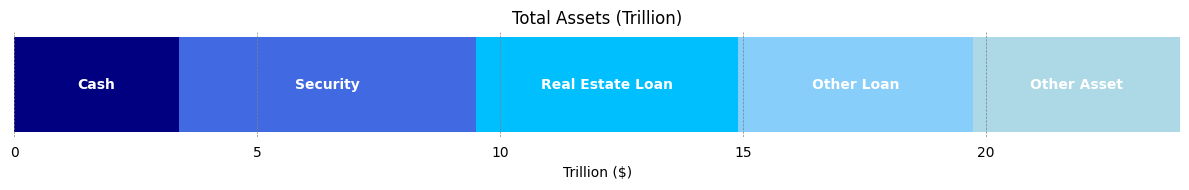

In [49]:
colors_assets = ['navy', 'royalblue', 'deepskyblue', 'lightskyblue', 'lightblue']

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 2))  # More width for better annotation visibility

# Starting point for the first segment of the bar
starting = 0

# Plot each category segment in the bar and annotate
for (category, value), color in zip(proportions.items(), colors_assets):
    ax.barh('Total Assets', value, left=starting, color=color)
    text_x = starting + value / 2  
    ax.text(text_x, 0, category, ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    starting += value

# Set the limits and labels for the x-axis
ax.set_xlim(0, 24)
ax.set_xlabel('Trillion ($)')

# Remove y-axis as we only have one bar
ax.get_yaxis().set_visible(False)

# Set the title
ax.set_title('Total Assets (Trillion)')

# Remove all spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove ticks for cleaner look
ax.tick_params(bottom=False, left=False)

# Show the grid for the x-axis only
ax.xaxis.grid(True, color='grey', linestyle='--', linewidth=0.5)

# Show the figure
plt.tight_layout()
plt.show()


In [ ]:
bank_liability = pd.read_csv('bank_liability.csv')  # Read DataFrame from CSV

In [50]:
aggregate_liability = bank_liability['Total Liability'].sum()
aggregate_Insured_Deposit = bank_liability['Insured Deposit'].sum()
aggregate_Uninsured_Deposit = bank_liability['Uninsured Deposit'].sum()
aggregate_Equity = bank_liability['Total Equity'].sum()
aggregate_Other_liability = aggregate_liability - aggregate_Insured_Deposit - aggregate_Uninsured_Deposit - aggregate_Equity

proportions_liability = {
    'Insured Deposit': (aggregate_Insured_Deposit / aggregate_liability) * 24,
    'Uninsured Deposit': (aggregate_Uninsured_Deposit / aggregate_liability) * 24,
    'Total Equity': (aggregate_Equity / aggregate_liability) * 24,
    'Other': (aggregate_Other_liability / aggregate_liability) * 24
}
proportions_liability

{'Insured Deposit': 2.0165676687457816,
 'Uninsured Deposit': 18.29545498434364,
 'Total Equity': 2.5085155103512173,
 'Other': 1.1794618365593625}

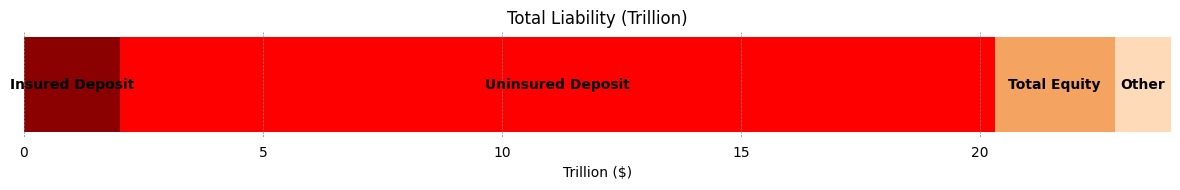

In [51]:

# Define the colors for each category in the liability section
colors_liabilities = ['darkred', 'red', 'sandybrown', 'peachpuff']

# Create figure and axes for the liabilities chart
fig, ax = plt.subplots(figsize=(12, 2))  # Similar size to the assets chart for consistency

# Starting point for the first segment of the liability bar
starting_liability = 0

# Plot each category segment in the bar and annotate for liabilities
for (category, value), color in zip(proportions_liability.items(), colors_liabilities):
    ax.barh('Total Liability', value, left=starting_liability, color=color)
    # Annotate the segment with the category name
    text_x = starting_liability + value / 2  # Position the text in the middle of the segment
    ax.text(text_x, 0, category, ha='center', va='center', color='black', fontsize=10, fontweight='bold')
    starting_liability += value

# Set the limits and labels for the x-axis
ax.set_xlim(0, 24)
ax.set_xlabel('Trillion ($)')

# Remove y-axis as we only have one bar
ax.get_yaxis().set_visible(False)

# Set the title
ax.set_title('Total Liability (Trillion)')

# Remove all spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove ticks for cleaner look
ax.tick_params(bottom=False, left=False)

# Show the grid for the x-axis only
ax.xaxis.grid(True, color='grey', linestyle='--', linewidth=0.5)

# Show the figure
plt.tight_layout()
plt.show()
